## Import packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=500, frameon=False, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=True)

## Load

In [2]:
tmp = sc.read('data/somitoid_processed.h5ad')
somitoid = sc.AnnData(tmp.raw.X,obs=tmp.obs,var=tmp.raw.var,uns=tmp.uns,obsm=tmp.obsm,obsp=tmp.obsp)
somitoid.obs['type'] = 'somitoid'

In [3]:
sc.pp.filter_cells(somitoid, min_counts=4000)
sc.pp.filter_cells(somitoid, max_counts=65000)
sc.pp.filter_cells(somitoid, min_genes=3000)
sc.pp.filter_cells(somitoid, max_genes=8000)

In [4]:
tmp = sc.read('data/segmentoid_processed.h5ad')
segmentoid = sc.AnnData(tmp.raw.X,obs=tmp.obs,var=tmp.raw.var,uns=tmp.uns,obsm=tmp.obsm,obsp=tmp.obsp)
segmentoid.obs['type'] = 'segmentoid'

In [5]:
sc.pp.filter_cells(segmentoid, min_counts=4000)
sc.pp.filter_cells(segmentoid, max_counts=65000)
sc.pp.filter_cells(segmentoid, min_genes=3000)
sc.pp.filter_cells(segmentoid, max_genes=8000)

In [6]:
mouse = sc.read('data/mouse_9_5_diazcuadros_rawhidden_converted_to_human.h5ad')
mouse.var_names_make_unique()
mouse.obs['type'] = 'mouse'

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
adata = segmentoid.concatenate(mouse, somitoid)

## Pre process

In [8]:
cell_cycle_genes = [x.strip() for x in open('utils/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [9]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)
adata = adata[adata.obs['pct_counts_mito'] < 10, :]

In [10]:
adata.raw = adata

In [11]:
sc.pp.normalize_total(adata)

In [12]:
sc.pp.log1p(adata)

In [13]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

In [14]:
sc.pp.regress_out(adata, ['total_counts', 'S_score', 'G2M_score'], n_jobs = 16)

... storing 'sample' as categorical
... storing 'type' as categorical
... storing 'timepoint' as categorical
... storing 'phase' as categorical
... storing 'leiden' as categorical


In [15]:
sc.pp.scale(adata)

In [16]:
sc.tl.pca(adata)

In [17]:
sce.pp.harmony_integrate(adata, 'type')
sc.pp.neighbors(adata, use_rep = 'X_pca_harmony')

2022-10-29 20:03:49,499 - harmonypy - INFO - Iteration 1 of 10
2022-10-29 20:03:54,803 - harmonypy - INFO - Iteration 2 of 10
2022-10-29 20:04:00,163 - harmonypy - INFO - Converged after 2 iterations


In [18]:
sc.tl.umap(adata)

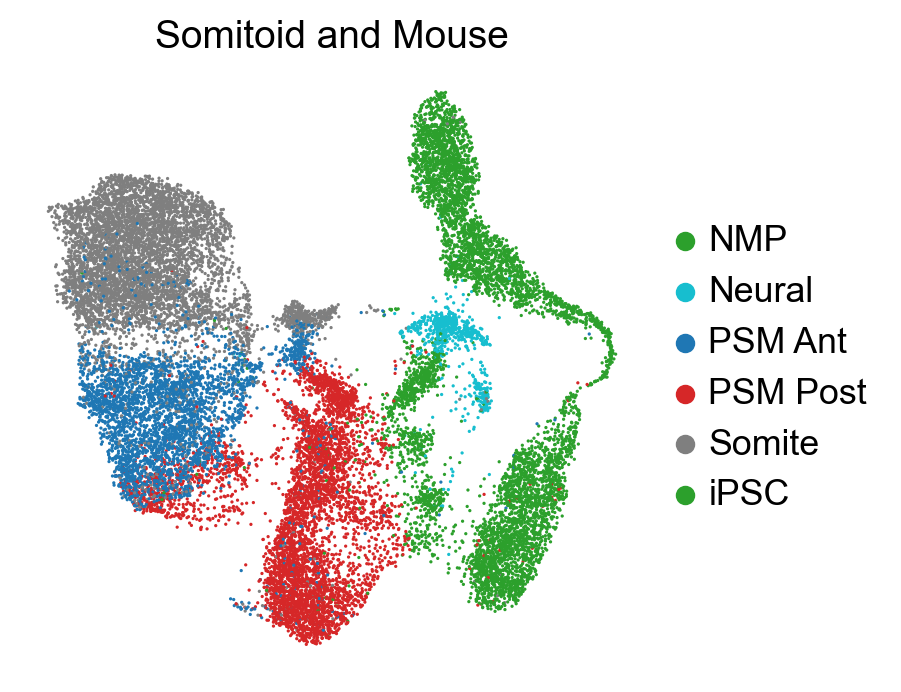

In [19]:
sc.pl.umap(adata, color=['leiden'], title='Somitoid and Mouse', palette=['tab:green',  'tab:cyan', 'tab:blue', 'tab:red', 'tab:gray'], save='somitoid_and_mouse_leiden.pdf')

... storing 'leiden_type' as categorical


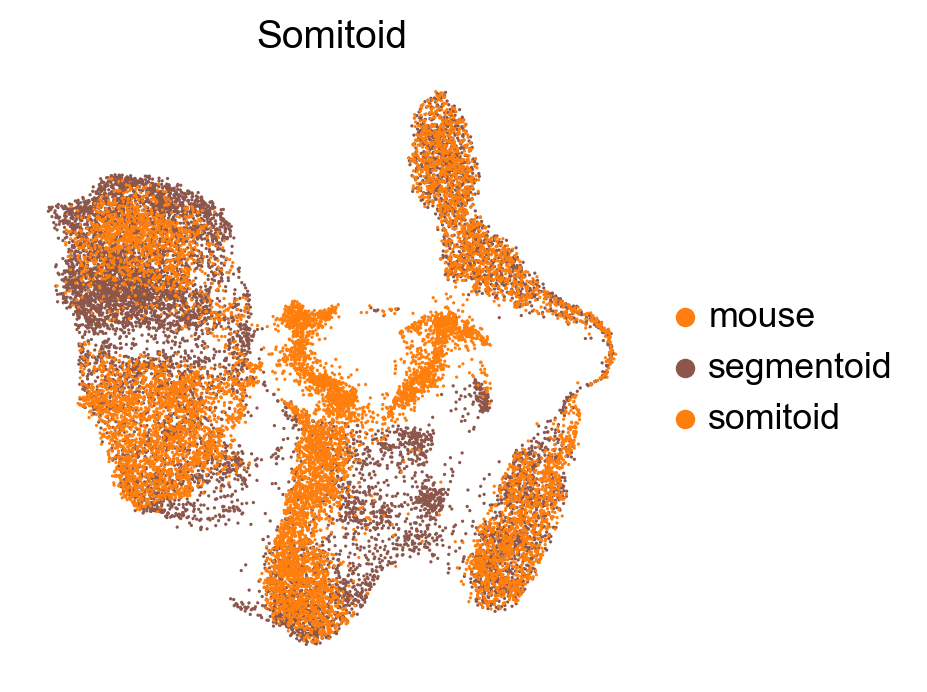

In [23]:
sc.pl.umap(adata, color=['type'], title='Somitoid', save='somitoid_and_mouse_type.pdf')

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=True, method='wilcoxon', corr_method='benjamini-hochberg')
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
diffgenelist_toall_pval=pd.DataFrame({group + '_' + key: result[key][group] for group in 
                                      groups for key in ['names']})
diffgenelist_toall_pval.to_excel('segmentoid_and_mouse_DEG.xlsx')

In [ ]:
diffgenelist_toall_pval.head(3)

In [22]:
adata.obs['leiden_type'] = '0'
for x in list(range(0, len(adata.obs_names))):
    adata.obs['leiden_type'][x] = adata.obs.leiden[x] + ' ' + adata.obs.type[x]

C:\Users\Yannis\AppData\Local\Temp\ipykernel_25740\2493396734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['leiden_type'][x] = adata.obs.leiden[x] + ' ' + adata.obs.type[x]


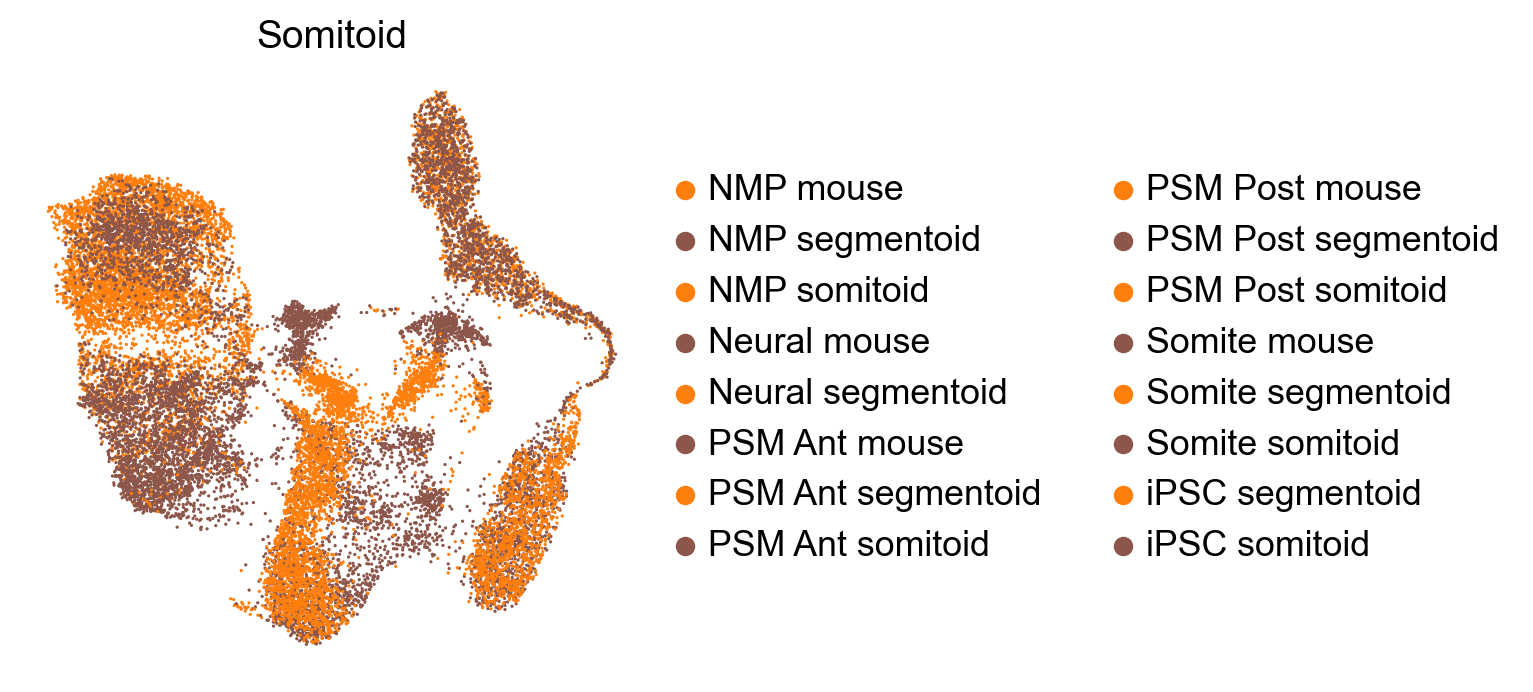

In [24]:
sc.pl.umap(adata, color=['leiden_type'], title='Somitoid', palette=['tab:orange', 'tab:brown'], save='somitoid_and_mouse_type.pdf')

In [39]:
marker_genes = {
    'NMP': {'NKX1-2', 'TBXT'},
    'Neural': {'SOX2', 'PAX6'},
    'PSM Post': {'HES7', 'TBX6', 'DLL1'},
    'PSM Ant': {'RIPPLY2', 'MEOX1', 'MESP2', 'TCF15', 'MYOCD'},
    'Somite': {'UNCX', 'TBX18', 'PAX3'}
}

markers_genes = ['NKX1-2', 'TBXT', 'SOX2', 'PAX6', 'HES7', 'TBX6', 'DLL1', 'RIPPLY2', 'MEOX1', 'MESP2', 'TCF15', 'MYOCD', 'UNCX', 'TBX18', 'PAX3']

In [36]:
adata_without_ipsc = adata[~adata.obs['leiden_type'].isin(['iPSC somitoid', 'iPSC segmentoid']),:]

In [37]:
orderrr = ['NMP mouse','NMP segmentoid', 'NMP somitoid',
           'Neural mouse',  'Neural segmentoid',
        'PSM Post mouse','PSM Post segmentoid', 'PSM Post somitoid', 
           'PSM Ant mouse', 'PSM Ant segmentoid', 'PSM Ant somitoid',
           'Somite mouse', 'Somite segmentoid', 'Somite somitoid']

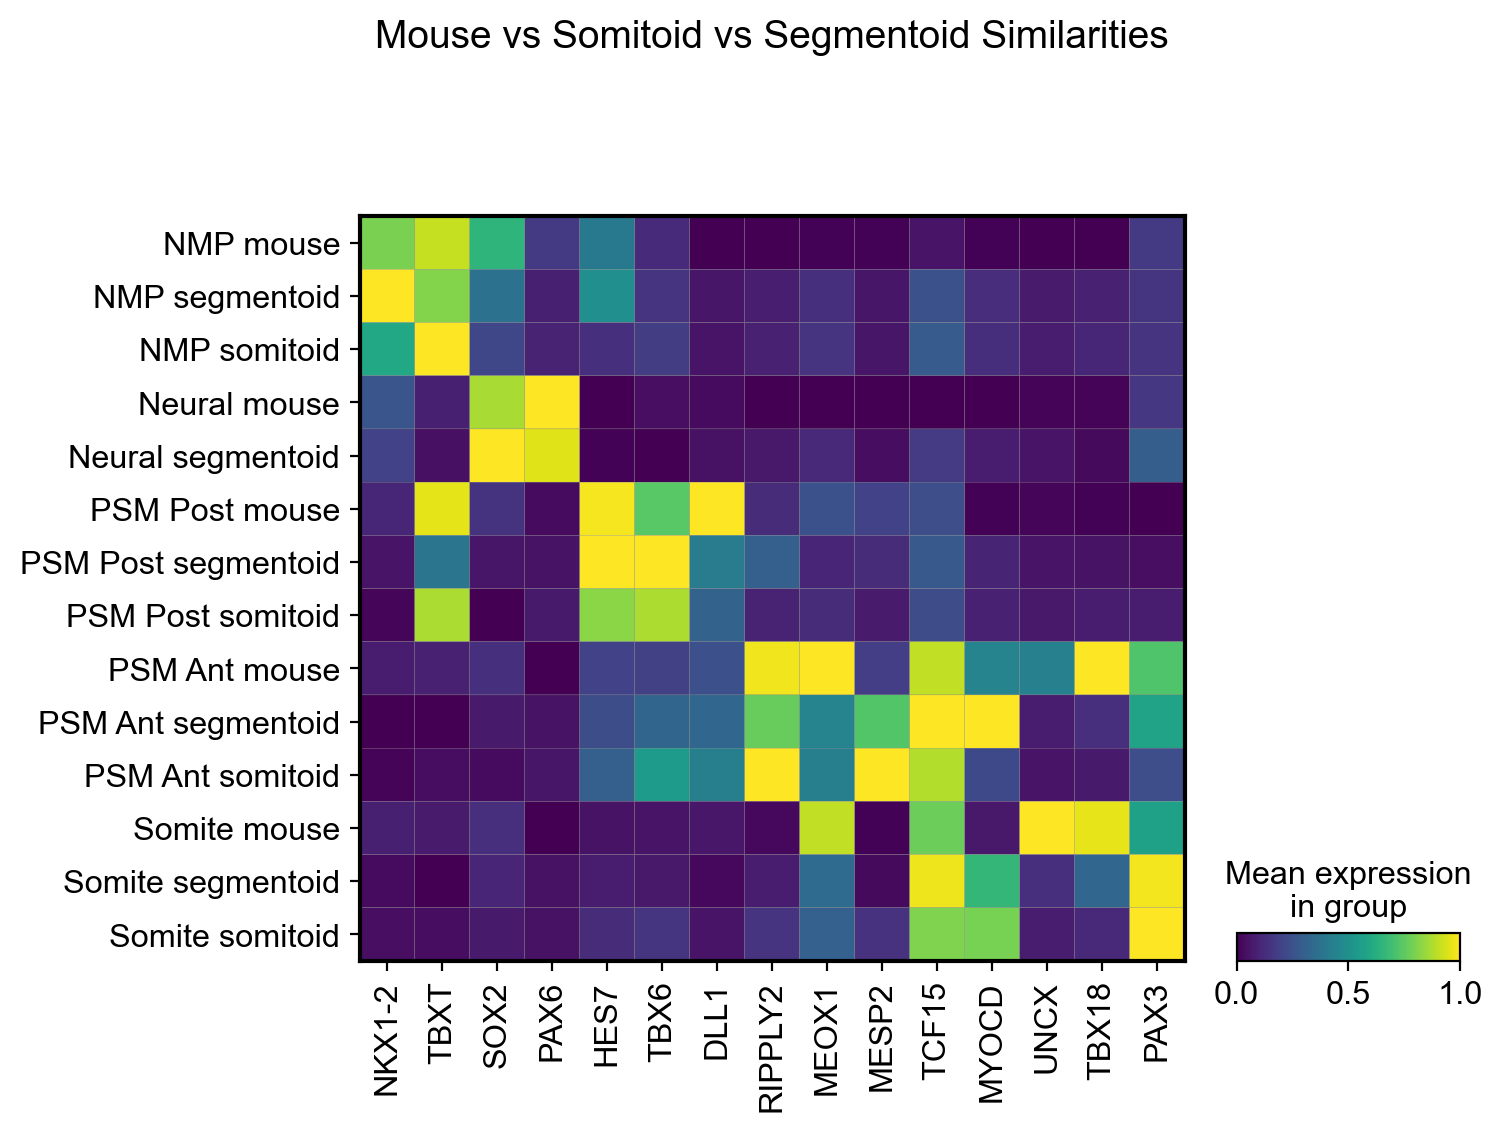

In [42]:
sc.pl.matrixplot(adata_without_ipsc, markers_genes,categories_order=orderrr, groupby='leiden_type', cmap='viridis',standard_scale='var', use_raw=False, title='Mouse vs Somitoid vs Segmentoid Similarities', save='somitoid_and_semgnetoid_mouse_similarities.pdf')